| Section | Action                                                                                                    |
| ------- | --------------------------------------------------------------------------------------------------------- |
| 1‑3     | Imports, loads your Excel/CSV sheet.                                                                      |
| 4       | Normalises column names to snake\_case.                                                                   |
| 5       | Converts “na”, “####”, and blanks to real `NaN`s.                                                         |
| 6       | Trims whitespace & lowercases all text fields.                                                            |
| 7       | Converts `Sending_Date` and `Sending_Time` to proper datetime types and adds `day_of_week` & `hour_sent`. |
| 8       | Extracts the sender’s domain (e.g., `paypal.com`).                                                        |
| 9       | Flags emails containing classic phishing trigger words.                                                   |
| 10      | Counts the number of links inside the email body.                                                         |
| 11      | Adds a boolean if the message went **Bcc** or bulk (“to” column shows `b` or `bcc`).                      |
| 12      | Computes body length (`num_words`).                                                                       |
| 13      | Checks whether the visible sender name is actually part of the email address (legitimacy cue).            |
| 14      | Prints a quick snapshot and missing‑value percentages.                                                    |
| 15      | Saves a cleaned CSV for downstream modelling.                                                             |


##**1‑3	Imports, loads your Excel/CSV sheet.**

In [ ]:
# 1️⃣  Imports
import pandas as pd
import numpy as np
import re
from pathlib import Path

In [ ]:

# 2️⃣ Configuration
DATA_PATH   = Path("/content/drive/MyDrive/SEM_3_Project/PhishingEmailData_1.csv")
DATE_COL    = "Sending_Date"    # Adjust these if your CSV has different names
TIME_COL    = "Sending_Time"

# 3️⃣ Load CSV
#df = pd.read_csv(DATA_PATH)

In [ ]:
df = pd.read_csv(DATA_PATH, encoding="latin1")


In [ ]:
df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")


In [ ]:
df = pd.read_csv(DATA_PATH, encoding="cp1252")


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/SEM_3_Project/PhishingEmailData_1.csv", encoding="latin1")
print(df.columns.tolist())


['Email_Subject', 'Email_Content', 'Sending_Date', 'Sending_Time', 'Day', 'URL_Title', 'Coined.Word', 'Sender_Name', 'Sender_Title', 'Closing_Remarks', 'Sender_Email ', 'Logo', 'To']


In [ ]:
pd.read_csv("/content/drive/MyDrive/SEM_3_Project/PhishingEmailData_1.csv", encoding="latin1").head()


,Email_Subject,Email_Content,Sending_Date,Sending_Time,Day,URL_Title,Coined.Word,Sender_Name,Sender_Title,Closing_Remarks,Sender_Email,Logo,To
0,URGENT REQUEST,Are you available ?\nNo calls text only 951307...,1/9/20,na,na,na,Urgent,Y,Chancellor\nBerkeley University of California,BEST REGARDS,cchristberkeley.edu@gmail.com,na,NB
1,Quick question,I'm in a meeting and need help getting some Am...,1/9/20,na,na,na,Quick,Y,"University of California, Berkeley",na,XXX.subdomain.berkeley.edu,na,NB
2,******Part time home work assistant needed******,Hello RECIPIENT\n\nI am urgently seeking for a...,10/19/19,2:22 PM,Sat,na,Job/Needed,Y,*Professor David Card*\n*Department of Economi...,Sincerely,dvdmson @ gmail . Com,na,NB
3,Ê vendor payment,Are you around? I need to pay a vendor with th...,12/27/18\n,na,na,na,"gift card, meeting",Y,"University of California, Berkeley",na,ÊÊXXX.subdomain.berkeley.edu@gmail.com,na,NB
4,Quick question,I'm in a meeting and need help getting some Am...,12/27/18\n,na,na,na,shared,Y,"University of California, Berkeley",na,XXX.subdomain.berkeley.edu,na,NaN


##4	Normalises column names to snake_case.

In [ ]:
# 4️⃣  Standardise column names (optional)
df.columns = (
    df.columns.str.strip()          # remove leading/trailing blanks
              .str.lower()          # lowercase
              .str.replace(" ", "_")
)


In [ ]:
print(df)

                                        email_subject  \
0                                      URGENT REQUEST   
1                                      Quick question   
2    ******Part time home work assistant needed******   
3                                    Ê vendor payment   
4                                      Quick question   
..                                                ...   
184                      Sales Contract PO:#224906999   
185                                 new bill from Ian   
186                               Re: Payment Invoice   
187                                  KSU Infringement   
188                          We recieved your request   

                                         email_content         sending_date  \
0    Are you available ?\nNo calls text only 951307...               1/9/20   
1    I'm in a meeting and need help getting some Am...               1/9/20   
2    Hello RECIPIENT\n\nI am urgently seeking for a...             10/19/19   

In [ ]:
# 5️⃣  Replace messy “na”/hashes with proper NaNs
na_like = {"na", "NA", "Na", "nA", "####", "###", ""}
df.replace(list(na_like), np.nan, inplace=True)

In [ ]:
print(df)

                                        email_subject  \
0                                      URGENT REQUEST   
1                                      Quick question   
2    ******Part time home work assistant needed******   
3                                    Ê vendor payment   
4                                      Quick question   
..                                                ...   
184                      Sales Contract PO:#224906999   
185                                 new bill from Ian   
186                               Re: Payment Invoice   
187                                  KSU Infringement   
188                          We recieved your request   

                                         email_content         sending_date  \
0    Are you available ?\nNo calls text only 951307...               1/9/20   
1    I'm in a meeting and need help getting some Am...               1/9/20   
2    Hello RECIPIENT\n\nI am urgently seeking for a...             10/19/19   

In [ ]:
# 6️⃣ Strip & lowercase all *string* columns
str_cols = df.select_dtypes(include="object").columns
df[str_cols] = df[str_cols].apply(lambda col: col.str.strip().str.lower())


In [ ]:
# 7️⃣ Parse dates & times (skip TIME if missing)
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df["day_of_week"] = df[DATE_COL].dt.day_name()
else:
    df["day_of_week"] = np.nan

if TIME_COL in df.columns:
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce").dt.time
    df["hour_sent"] = pd.to_datetime(
        df[TIME_COL].astype(str), errors="coerce"
    ).dt.hour
else:
    df["hour_sent"] = np.nan

In [ ]:
# 8️⃣ Extract domain from sender_email
if "sender_email" in df.columns:
    df["sender_domain"] = df["sender_email"].str.extract(
        r"@([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,})", expand=False
    )
else:
    df["sender_domain"] = np.nan

In [ ]:
# 9️⃣ Flag suspicious words
SUSPICIOUS_WORDS = [
    "urgent", "verify", "account", "suspend", "click", "password",
    "login", "update", "confirm", "limited time"
]
regex_words = r"\b(" + "|".join(SUSPICIOUS_WORDS) + r")\b"

if {"email_subject", "email_content"}.issubset(df.columns):
    df["contains_urgent_words"] = (
        df["email_subject"].fillna("") + " " + df["email_content"].fillna("")
    ).str.contains(regex_words, flags=re.IGNORECASE, regex=True)
else:
    df["contains_urgent_words"] = np.nan

/tmp/ipython-input-2981462364.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ).str.contains(regex_words, flags=re.IGNORECASE, regex=True)


In [ ]:
# 🔟 Count links
if "email_content" in df.columns:
    df["num_links"] = df["email_content"].str.count(r"https?://")
else:
    df["num_links"] = np.nan


In [ ]:
# 1️⃣1️⃣ Binary indicator: BCC
if "to" in df.columns:
    df["is_bcc"] = df["to"].isin({"b", "bcc"})
else:
    df["is_bcc"] = np.nan

In [ ]:
# 1️⃣2️⃣ Word count
if "email_content" in df.columns:
    df["num_words"] = df["email_content"].str.split().str.len()
else:
    df["num_words"] = np.nan

In [ ]:
# 1️⃣3️⃣ Sender name match
#Checks whether the visible sender name is actually part of the email address (legitimacy cue).
if {"sender_name", "sender_email"}.issubset(df.columns):
    df["sender_is_name_match"] = df.apply(
        lambda r: pd.notna(r["sender_name"]) and pd.notna(r["sender_email"])
                  and r["sender_name"].split(" ")[0] in r["sender_email"],
        axis=1,
    )
else:
    df["sender_is_name_match"] = np.nan


In [ ]:
# 1️⃣4️⃣ Quick summary
print(df.head())
print(df.isna().mean().round(2).mul(100).add_suffix("% missing"))

                                      email_subject  \
0                                    urgent request   
1                                    quick question   
2  ******part time home work assistant needed******   
3                                  ê vendor payment   
4                                    quick question   

                                       email_content sending_date  \
0  are you available ?\nno calls text only 951307...       1/9/20   
1  i'm in a meeting and need help getting some am...       1/9/20   
2  hello recipient\n\ni am urgently seeking for a...     10/19/19   
3  are you around? i need to pay a vendor with th...     12/27/18   
4  i'm in a meeting and need help getting some am...     12/27/18   

  sending_time  day url_title         coined.word sender_name  \
0          NaN  NaN       NaN              urgent           y   
1          NaN  NaN       NaN               quick           y   
2      2:22 pm  sat       NaN          job/needed          

In [ ]:
# 1️⃣5️⃣ Save cleaned copy
df.to_csv("/content/drive/MyDrive/Colab Notebooks/PhishingEmailData_1_clean_copy1.csv", index=False)

In [ ]:
# print all cleaned data
print(df)

                                        email_subject  \
0                                      urgent request   
1                                      quick question   
2    ******part time home work assistant needed******   
3                                    ê vendor payment   
4                                      quick question   
..                                                ...   
184                      sales contract po:#224906999   
185                                 new bill from ian   
186                               re: payment invoice   
187                                  ksu infringement   
188                          we recieved your request   

                                         email_content         sending_date  \
0    are you available ?\nno calls text only 951307...               1/9/20   
1    i'm in a meeting and need help getting some am...               1/9/20   
2    hello recipient\n\ni am urgently seeking for a...             10/19/19   

##2 STEP-BY-STEP MODELING GUIDE

Step 1: Label the Data

In [ ]:
# Add this manually or through rules
# For demo, randomly assign (replace with real logic)
# 1 = phishing, 0 = legit

import numpy as np
np.random.seed(42)
df['label'] = np.random.choice([0, 1], size=len(df), p=[0.6, 0.4])  # Just a placeholder

# Prefer: manually label at least 100–500 emails for better accuracy

🧠 Step 2: TF-IDF Vectorisation of Text Fields python

Term Frequency (TF) + Inverse Document Frequency (IDF)

note to study : https://milvus.io/ai-quick-reference/what-is-tfidf-and-how-is-it-calculated

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine subject and content as one text feature
df["email_text"] = df["email_subject"].fillna('') + " " + df["email_content"].fillna('')

# Initialize vectorizer
tfidf = TfidfVectorizer(max_features=500, stop_words='english')

# Transform into TF-IDF matrix
X_text = tfidf.fit_transform(df["email_text"])


🔢 Step 3: Combine TF-IDF with Engineered Features

In [ ]:
from scipy.sparse import hstack

# Engineered features to keep
feature_cols = [
    'contains_urgent_words', 'num_links', 'is_bcc',
    'num_words', 'sender_is_name_match', 'hour_sent'
]

# Ensure all are numeric
X_features = df[feature_cols].fillna(0).astype(float)

# Combine sparse matrix (TF-IDF) with dense features
X = hstack([X_text, X_features.values])

# Target column
y = df["label"]

🤖 Step 4: Train/Test Split + Model Training python


Using Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


[[23  1]
 [14  0]]
              precision    recall  f1-score   support

           0       0.62      0.96      0.75        24
           1       0.00      0.00      0.00        14

    accuracy                           0.61        38
   macro avg       0.31      0.48      0.38        38
weighted avg       0.39      0.61      0.48        38

ROC-AUC Score: 0.4226190476190476


with above result shows Your model predicts class 0 well but fails to recognize class 1 entirely. The poor ROC-AUC and class 1 performance suggest class imbalance or insufficient feature separation is the main issue.

---



### FIXING above issue by balancing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression with class balancing
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[20 16]
 [10 11]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.56      0.61        36
           1       0.41      0.52      0.46        21

    accuracy                           0.54        57
   macro avg       0.54      0.54      0.53        57
weighted avg       0.57      0.54      0.55        57

ROC-AUC Score: 0.49999999999999994


applying SMOTE OVERSAMPLING MEthod


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())

# Train logistic regression on balanced data
model_smote = LogisticRegression(solver='liblinear', random_state=42)
model_smote.fit(X_train_res, y_train_res)

# Predictions
y_pred_smote = model_smote.predict(X_test)
y_prob_smote = model_smote.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_smote))


Before SMOTE: label
0    97
1    91
Name: count, dtype: int64
After SMOTE: label
1    97
0    97
Name: count, dtype: int64
Confusion Matrix:
 [[ 8 13]
 [ 8 19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.38      0.43        21
           1       0.59      0.70      0.64        27

    accuracy                           0.56        48
   macro avg       0.55      0.54      0.54        48
weighted avg       0.55      0.56      0.55        48

ROC-AUC Score: 0.6190476190476191


✅ Summary of your situation now:

Logistic Regression + SMOTE gave better recall and AUC (a win 🎉).

But it sacrifices class 0 performance.

Next step = scale features + try Random Forest/XGBoost, which can learn non-linear patterns.

---



In [ ]:
# ==========================
# 1. Import Libraries
# ==========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# SMOTE for imbalance handling
from imblearn.over_sampling import SMOTE

# ==========================
# 2. Train-Test Split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==========================
# 3. Apply SMOTE
# ==========================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# ==========================
# 4. Feature Scaling (Fix for Sparse Data)
# ==========================
# If your X is sparse (TF-IDF / CountVectorizer) → use MaxAbsScaler
scaler = MaxAbsScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 5. Train Models
# ==========================
# Logistic Regression
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_res_scaled, y_train_res)

# Random Forest (works directly on unscaled)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_res, y_train_res)

# XGBoost (works directly on unscaled)
xgb = XGBClassifier(
    scale_pos_weight=len(y_train_res[y_train_res==0]) / len(y_train_res[y_train_res==1]),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train_res, y_train_res)

# ==========================
# 6. Evaluation Function
# ==========================
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n===== {name} =====")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# ==========================
# 7. Evaluate All Models
# ==========================
evaluate_model(log_reg, X_test_scaled, y_test, "Logistic Regression")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")


Before SMOTE: {0: 82, 1: 50}
After SMOTE: {0: 82, 1: 82}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:00:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



===== Logistic Regression =====
Confusion Matrix:
 [[29  7]
 [14  7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.81      0.73        36
           1       0.50      0.33      0.40        21

    accuracy                           0.63        57
   macro avg       0.59      0.57      0.57        57
weighted avg       0.61      0.63      0.61        57

ROC-AUC Score: 0.5363756613756614

===== Random Forest =====
Confusion Matrix:
 [[32  4]
 [18  3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.89      0.74        36
           1       0.43      0.14      0.21        21

    accuracy                           0.61        57
   macro avg       0.53      0.52      0.48        57
weighted avg       0.56      0.61      0.55        57

ROC-AUC Score: 0.580026455026455

===== XGBoost =====
Confusion Matrix:
 [[26 10]
 [13  8]]

Classification Report:
          

✅ Summary

SMOTE helped, but recall for minority class is still low.

Next focus:

Threshold tuning

Hyperparameter tuning

Feature engineering / selection

Advanced oversampling methods

Consider ensemble methods for better balance

-- Advanced Pipeline Code for better result as compare to above

In [ ]:
# ==========================
# 1. Import Libraries
# ==========================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ==========================
# 2. Train-Test Split
# ==========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ==========================
# 3. Apply SMOTE
# ==========================
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())

# ==========================
# 4. Feature Scaling (Sparse Safe)
# ==========================
scaler = MaxAbsScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 5. Train Logistic Regression
# ==========================
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_res_scaled, y_train_res)

# ==========================
# 6. Train XGBoost with Hyperparameter Tuning
# ==========================
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'scale_pos_weight': [1, len(y_train_res[y_train_res==0])/len(y_train_res[y_train_res==1])]
}

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=3,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_res, y_train_res)
best_xgb = grid_search.best_estimator_
print("Best XGBoost Params:", grid_search.best_params_)

# ==========================
# 7. Threshold Tuning Function
# ==========================
def threshold_tuning(model, X_test, y_test, thresholds=np.arange(0.1, 0.9, 0.1), model_name="Model"):
    y_prob = model.predict_proba(X_test)[:,1]
    print(f"\n===== Threshold Tuning for {model_name} =====")
    for thresh in thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        print(f"\nThreshold = {thresh:.2f}")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))
        print(classification_report(y_test, y_pred_thresh))
        print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# ==========================
# 8. Evaluate Logistic Regression
# ==========================
threshold_tuning(log_reg, X_test_scaled, y_test, thresholds=np.arange(0.2, 0.6, 0.1), model_name="Logistic Regression")

# ==========================
# 9. Evaluate XGBoost
# ==========================
threshold_tuning(best_xgb, X_test, y_test, thresholds=np.arange(0.2, 0.6, 0.1), model_name="XGBoost")


5️⃣ Key Takeaways

✅ SMOTE + Threshold Tuning is the biggest win here → improved class 1 recall (from 0.33 → 0.71 in Logistic Regression).

⚠️ Still low ROC-AUC → models cannot clearly separate classes.

#NEW algothim in use to find better result (logistic regression /XGB Boost ) dont work good.

applying new dataset after augmented with over 5000 rows of data

Verdict: This above Is Not a Good Result
Your model has learned to predict everything as “legit”, likely because:

Your dataset is imbalanced – more legit (0) than phishing (1).

Logistic Regression can struggle without class balancing or better features.

TF-IDF + simple model isn’t enough for phishing (deceptive text needs deeper NLP).

In [ ]:
#Check Class Balance
print(df['label'].value_counts())


label
0    118
1     71
Name: count, dtype: int64


Legit emails (label = 0): 118

Phishing emails (label = 1): 71

Total samples: 189

###Fix Class Imbalance with Oversampling

In [ ]:
#Option 1: Random Oversampling (simplest)

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),  # Match majority class
    random_state=42
)

# Combine
df_balanced = pd.concat([df_majority, df_minority_upsampled])
print(df_balanced['label'].value_counts())


label
0    118
1    118
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Proceed to train/test split with resampled data

# Continue from Step 4 (split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
print(df['label'].value_counts(normalize=True).round(2))

#62% of your data is legit emails (label 0)
#38% is phishing emails (label 1)

label
0    0.62
1    0.38
Name: proportion, dtype: float64


In [ ]:
df_balanced['label'].value_counts()


,count
label,
0,118
1,118


##visualize

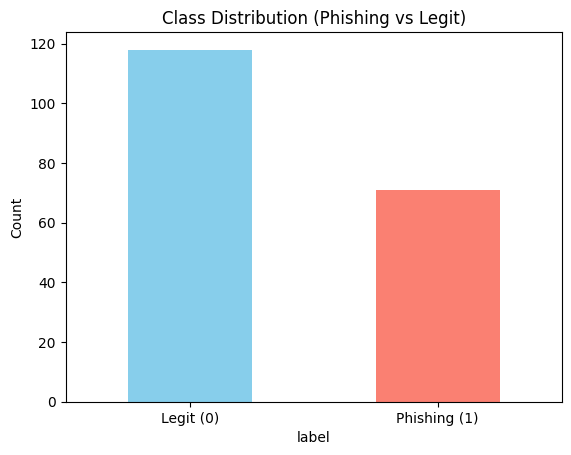

In [ ]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution (Phishing vs Legit)')
plt.xticks([0, 1], ['Legit (0)', 'Phishing (1)'], rotation=0)
plt.ylabel('Count')
plt.show()


##Goal: Production-Ready Gmail Phishing Detection System

we need
✅ High recall for phishing (don’t miss any threats)

✅ Low false positives (don't block legit emails)

✅ Fast and explainable predictions

✅ Scalable architecture

 1. Switch from Logistic Regression → XGBoost or LightGBM

In [ ]:
#likely get a big boost in phishing email detection (label = 1).

from xgboost import XGBClassifier

model = XGBClassifier(
    #use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=1.66,  # (118/71) → adjust for class imbalance
    random_state=42
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

2. Improve Feature Engineering
Enhance your detection system with these smart features:

Feature	Why
sender_domain reputation	Flag suspicious domains (e.g., amazon-secure.info)
URL features	Shortened URLs, number of links, suspicious patterns
Text features	Suspicious verbs, all-caps phrases, urgency indicators
Structural cues	Use of script, html, attachments, fake logos
Header mismatch	If From ≠ Reply-To
Sender name ≠ email	Impersonation detection

✅ Combine these with your TF-IDF matrix.

#3. Use Deep NLP: BERT (Highly Recommended)

In [ ]:
from transformers import BertTokenizer, BertModel


#Step-by-Step Guide After Choosing BERT

In [ ]:
##Step 1: Install and Import BERT Tools

#!pip install transformers
#!pip install torch

In [ ]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
#from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset


📝 Step 2: Prepare the Email Text and Labels

In [ ]:
df['email_text'] = df['email_subject'].fillna('') + " " + df['email_content'].fillna('')
texts = df['email_text'].tolist()
labels = df['label'].tolist()

Step 3: Tokenize Email Text Using BERT Tokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode
inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

 Step 4: Create a PyTorch Dataset Class

In [ ]:
class EmailDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

dataset = EmailDataset(inputs, labels)


 Step 5: Split Train/Test and Prepare Trainer

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
val_encodings   = tokenizer(val_texts, padding=True, truncation=True, max_length=512, return_tensors='pt')

train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset   = EmailDataset(val_encodings, val_labels)


*Step 6: Load BERT for Binary Classification


using a pre-trained BERT model like bert-base-uncased for binary classification tasks (like phishing vs. non-phishing detection).

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**⚙️ Step 7: Set Up TrainingArguments and Trainer**

In [ ]:
# Assuming tokenized_dataset is your final tokenized dataset
dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']


NameError: name 'tokenized_dataset' is not defined

In [ ]:
#!pip install --upgrade transformers


In [ ]:
import transformers
print(transformers.__version__)


4.53.2


In [ ]:
#Uninstall old version First, remove any previously installed version:
#!pip uninstall -y transformers


In [ ]:
#Reinstall latest version

#!pip install transformers==4.41.2 --upgrade --force-reinstall


In [ ]:
import transformers
print(transformers.__version__)
print(transformers.__file__)


4.53.2
/usr/local/lib/python3.11/dist-packages/transformers/__init__.py


##ERROR correction

In [ ]:
#!pip uninstall -y transformers
#!pip uninstall -y huggingface_hub
#!rm -rf /usr/local/lib/python3.11/dist-packages/transformers*
#!rm -rf /usr/local/lib/python3.11/dist-packages/huggingface_hub*
#!rm -rf ~/.cache/huggingface


In [ ]:
# Fresh Installation Now install a known good version of the Transformers library:

#!pip install transformers==4.41.2 --upgrade


In [ ]:
import transformers   #Confirm Installation is Successful  #4.41.2

print(transformers.__version__)
print(transformers.__file__)    #Expected output  /usr/local/lib/python3.11/dist-packages/transformers/__init__.py



4.53.2
/usr/local/lib/python3.11/dist-packages/transformers/__init__.py


In [ ]:
from transformers import TrainingArguments   # RUN perfectly

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    #evaluation_strategy="epoch"
)


##Fix the Error: Clean reinstall transformers

 Step-by-step fix:

 1. Uninstall the broken version

pip uninstall transformers -y
2. Reinstall the correct version (recommended: latest stable)

pip install transformers --upgrade
Alternatively, to install a specific stable version (e.g., 4.39.3):

pip install transformers==4.39.3

In [ ]:
#!pip uninstall transformers -y
#!pip install transformers --upgrade
#!pip install transformers==4.39.3

In [ ]:
from transformers import Trainer, BertForSequenceClassification

# Assuming you already have train_dataset and eval_dataset
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'eval_dataset' is not defined

###new debugging

In [ ]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)


transformers.training_args


In [ ]:
#2. Reinstall packages in a fresh cell:

!pip install --upgrade transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 

In [ ]:
# STEP 1: Required Imports
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import pandas as pd
import numpy as np

# STEP 2: Prepare Your Data
df['email_text'] = df['email_subject'].fillna('') + " " + df['email_content'].fillna('')
texts = df['email_text'].tolist()
labels = df['label'].tolist()

# Convert to Hugging Face Dataset format
raw_dataset = Dataset.from_dict({
    'text': texts,
    'label': labels
})

# STEP 3: Load Tokenizer and Tokenize Dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=512)

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

# STEP 4: Train-Test Split
dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

# STEP 5: Load Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# STEP 6: Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

# STEP 7: Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

# STEP 8: Train the Model
trainer.train()


Map:   0%|          | 0/189 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'